In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from generator_model import Generator
from discriminator_model import Discriminator
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
torch.backends.cudnn.benchmark = True





In [2]:
from skimage.metrics import structural_similarity as ssim
def calculate_metrics(img1_path, img2_path):
    # Read images
    # img1 = cv2.imread(img1_path)
    # img2 = cv2.imread(img2_path)
    img1 = img1_path
    img2 = img2_path
    # Convert to grayscale (optional; depends on use case)
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    # Convert to float for accurate computation
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(img1 - img2))

    # Mean Squared Error (MSE)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * log10(255.0 / sqrt(mse))

    # SSIM (computed per channel if RGB)
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        ssim_value = np.mean([ssim(img1[..., i], img2[..., i], data_range=255) for i in range(3)])
    else:
        ssim_value = ssim(img1, img2, data_range=255)

    return psnr, ssim_value, mae


# # Example usage:
# if __name__ == "__main__":
#     # img1_path = "image1.png"
#     # img2_path = "image2.png"

#     psnr_value, ssim_value, mae_value = calculate_metrics(fake_ct_np, ct_np)
#     print(f"PSNR: {psnr_value:.4f} dB")
#     print(f"SSIM: {ssim_value:.4f}")
#     print(f"MAE:  {mae_value:.4f}")

In [3]:
class MyCustomDataset(Dataset):
    def __init__(self,train_path,test_path,image_size=(256, 256),aug=True):
        self.train_path = train_path
        self.test_path = test_path
        self.image_size = image_size
        self.aug = aug

        self.train_images = sorted(glob(os.path.join(train_path, '*.jpg')))
    def __len__(self):
        return len(self.train_images)

    def rotate(self,mr,ct):
        
        h, w = self.image_size
        center = (self.image_size[0] // 2, self.image_size[0] // 2)
        angle = np.random.uniform(-10, 10)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
        mr_rotated = cv2.warpAffine(mr, rotation_matrix, (w, h),borderMode=cv2.BORDER_REFLECT_101)
        ct_rotated = cv2.warpAffine(ct, rotation_matrix, (w, h),borderMode=cv2.BORDER_REFLECT_101)
        return mr_rotated,ct_rotated
        
    def hflip(self,mr,ct):
        mr_flipped = cv2.flip(mr, 1)
        ct_flipped = cv2.flip(ct, 1)
        return mr_flipped,ct_flipped

    def scaled(self, mr, ct):
        h, w = self.image_size
    
        # Random scale factor between 0.9 (zoom out) and 1.1 (zoom in)
        scale = np.random.uniform(0.9, 1.1)
    
        # Resize image
        scaled_mr = cv2.resize(mr, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        scaled_ct = cv2.resize(ct, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    
        # Get new size
        new_h, new_w = scaled_mr.shape[:2]
    
        # Crop or pad to original size (centered)
        top = max((new_h - h) // 2, 0)
        left = max((new_w - w) // 2, 0)
        bottom = top + h
        right = left + w
    
        # If scaled image is larger — crop center
        if scale >= 1.0:
            scaled_mr = scaled_mr[top:bottom, left:right]
            scaled_ct = scaled_ct[top:bottom, left:right]
        else:
            # If scaled image is smaller — pad to original size
            pad_top = (h - new_h) // 2
            pad_bottom = h - new_h - pad_top
            pad_left = (w - new_w) // 2
            pad_right = w - new_w - pad_left
    
            scaled_mr = cv2.copyMakeBorder(scaled_mr, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_REFLECT_101)
            scaled_ct = cv2.copyMakeBorder(scaled_ct, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_REFLECT_101)
    
        return scaled_mr, scaled_ct
        
    def translate(self, mr, ct):
        h, w = self.image_size
    
        # Max shift: 10% of width and height
        max_shift_x = int(0.1 * w)
        max_shift_y = int(0.1 * h)
    
        # Random shifts in x and y directions
        tx = np.random.randint(-max_shift_x, max_shift_x + 1)
        ty = np.random.randint(-max_shift_y, max_shift_y + 1)
    
        # Create translation matrix
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    
        # Apply translation
        mr_translated = cv2.warpAffine(mr, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT_101)
        ct_translated = cv2.warpAffine(ct, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    
        return mr_translated, ct_translated

    def elastic_deformation(self,image, dx, dy):
        shape = image.shape[:2]
    
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1)), np.reshape(x + dx, (-1))
    
        if image.ndim == 3:
            channels = []
            for c in range(image.shape[2]):
                channel = map_coordinates(image[..., c], indices, order=1, mode='reflect').reshape(shape)
                channels.append(channel)
            return np.stack(channels, axis=-1).astype(image.dtype)
        else:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape).astype(image.dtype)
    
    def elastic(self, mr, ct, alpha=30, sigma=4):
        shape = mr.shape[:2]
        random_state = np.random.RandomState(None)
    
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    
        mr_deformed = self.elastic_deformation(mr, dx, dy)
        ct_deformed = self.elastic_deformation(ct, dx, dy)
    
        return mr_deformed, ct_deformed

    def augment(self, mr, ct):
        # You can tweak these probabilities (0.5 = 50% chance)
        if np.random.rand() < 0.5:
            mr, ct = self.rotate(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.hflip(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.scaled(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.translate(mr, ct)
        # if np.random.rand() < 0.5:
        #     mr, ct = self.elastic(mr, ct)
    
        return mr, ct
    def __getitem__(self, idx):
        mr_path = self.train_images[idx]
        filename = os.path.basename(mr_path)

        # CT image path (should match filename)
        ct_path = os.path.join(self.test_path, filename)

        # Load with OpenCV (BGR by default)
        mr_img = cv2.imread(mr_path, cv2.IMREAD_COLOR)
        ct_img = cv2.imread(ct_path, cv2.IMREAD_COLOR)


        # Resize if needed
        if self.image_size is not None:
            mr_img = cv2.resize(mr_img, self.image_size)
            ct_img = cv2.resize(ct_img, self.image_size)
        if self.aug:
            mr_img, ct_img = self.augment(mr_img, ct_img)
        # Convert to float32
        # mr_img = mr_img.astype(np.float32)
        # ct_img = ct_img.astype(np.float32)
        mr_img = (mr_img - mr_img.min())/(mr_img.max()-mr_img.min())
        ct_img = (ct_img - ct_img.min())/(ct_img.max()-ct_img.min())
        
        # Convert to PyTorch tensors
        mr_tensor = torch.from_numpy(mr_img).permute(2, 0, 1).float()
        ct_tensor = torch.from_numpy(ct_img).permute(2, 0, 1).float()

        return mr_tensor,ct_tensor

In [4]:
# gen = Generator(in_channels=3, features=64).to('cuda:3')
gen = Generator(in_channels=3, out_channels=3).to('cuda:2')
gen.load_state_dict(torch.load('best_generator_aug.pth', map_location='cuda:2'))

<All keys matched successfully>

In [5]:
dataVal = MyCustomDataset('../../ct_mr_data/val//mr/','../../ct_mr_data/val//ct/',aug=False)
val_loader = DataLoader(dataVal, batch_size=1, shuffle=True)


In [6]:
def denormalize(tensor):
    return (tensor + 1) / 2

In [7]:
def calculate_metrics(img1, img2):
    """Compute PSNR, SSIM, and MAE between two uint8 images."""
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # MAE
    mae = np.mean(np.abs(img1 - img2))

    # MSE and PSNR
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * log10(255.0 / sqrt(mse))

    # SSIM
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        ssim_value = np.mean([ssim(img1[..., i], img2[..., i], data_range=255) for i in range(3)])
    else:
        ssim_value = ssim(img1, img2, data_range=255)

    return psnr, ssim_value, mae


# ==============================
# Main validation loop
# ==============================
psnr_scores, ssim_scores, mae_scores = [], [], []

with torch.no_grad():
    for idx, (mr, ct) in enumerate(val_loader):
        mr = mr.to('cuda:2')
        ct = ct.to('cuda:2')

        fake_ct = gen(mr)

        # Denormalize tensors
        # mr = denormalize(mr)
        # ct = denormalize(ct)
        # fake_ct = denormalize(fake_ct)

        # Convert tensors to numpy arrays (C, H, W → H, W, C)
        ct_np = ct.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        fake_ct_np = fake_ct.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

        # Scale to uint8 [0, 255]
        ct_np = np.clip(ct_np * 255, 0, 255).astype('uint8')
        fake_ct_np = np.clip(fake_ct_np * 255, 0, 255).astype('uint8')

        # Calculate metrics
        psnr_val, ssim_val, mae_val = calculate_metrics(fake_ct_np, ct_np)

        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)
        mae_scores.append(mae_val)

        print(f"[{idx+1}/{len(val_loader)}] PSNR: {psnr_val:.4f}, SSIM: {ssim_val:.4f}, MAE: {mae_val:.4f}")

# ==============================
# Average results
# ==============================
print("\n==== Validation Results ====")
print(f"Average PSNR: {np.mean(psnr_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
print(f"Average MAE:  {np.mean(mae_scores):.4f}")

[1/4420] PSNR: 22.0151, SSIM: 0.7322, MAE: 13.5321
[2/4420] PSNR: 19.1233, SSIM: 0.6628, MAE: 15.9103
[3/4420] PSNR: 22.0541, SSIM: 0.7599, MAE: 10.1847
[4/4420] PSNR: 21.8800, SSIM: 0.7401, MAE: 10.6338
[5/4420] PSNR: 19.4885, SSIM: 0.5846, MAE: 14.7043
[6/4420] PSNR: 21.8176, SSIM: 0.7202, MAE: 12.2832
[7/4420] PSNR: 23.7932, SSIM: 0.8046, MAE: 8.3788
[8/4420] PSNR: 22.2724, SSIM: 0.7688, MAE: 12.8297
[9/4420] PSNR: 22.1098, SSIM: 0.6529, MAE: 11.3873
[10/4420] PSNR: 18.7237, SSIM: 0.6195, MAE: 19.9311
[11/4420] PSNR: 17.5005, SSIM: 0.5971, MAE: 22.4950
[12/4420] PSNR: 21.7921, SSIM: 0.8120, MAE: 13.2788
[13/4420] PSNR: 19.6548, SSIM: 0.7309, MAE: 14.7060
[14/4420] PSNR: 21.7576, SSIM: 0.7004, MAE: 12.1586
[15/4420] PSNR: 22.7109, SSIM: 0.7594, MAE: 10.9904
[16/4420] PSNR: 9.7959, SSIM: 0.5390, MAE: 62.5584
[17/4420] PSNR: 20.0768, SSIM: 0.6011, MAE: 13.7626
[18/4420] PSNR: 22.6517, SSIM: 0.7249, MAE: 10.5371
[19/4420] PSNR: 20.4652, SSIM: 0.6280, MAE: 15.2598
[20/4420] PSNR: 15.9935

KeyboardInterrupt: 

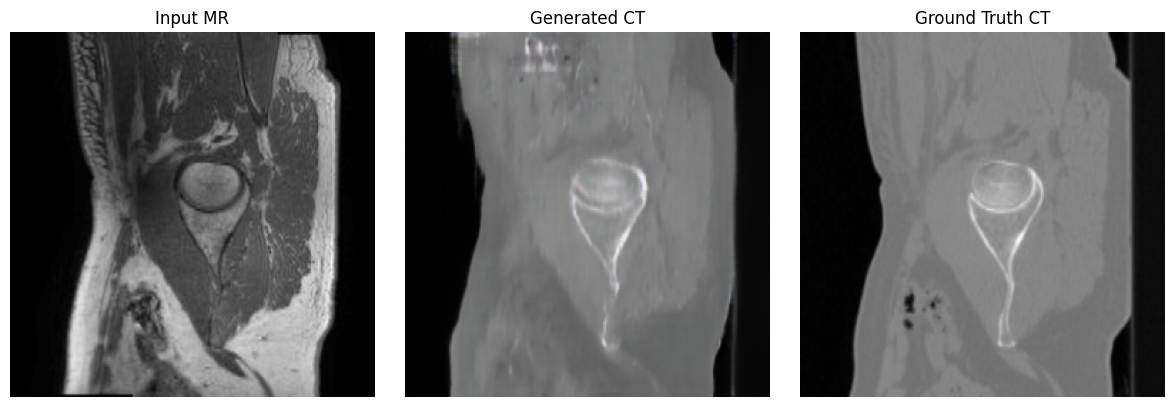

Press Enter to continue... 


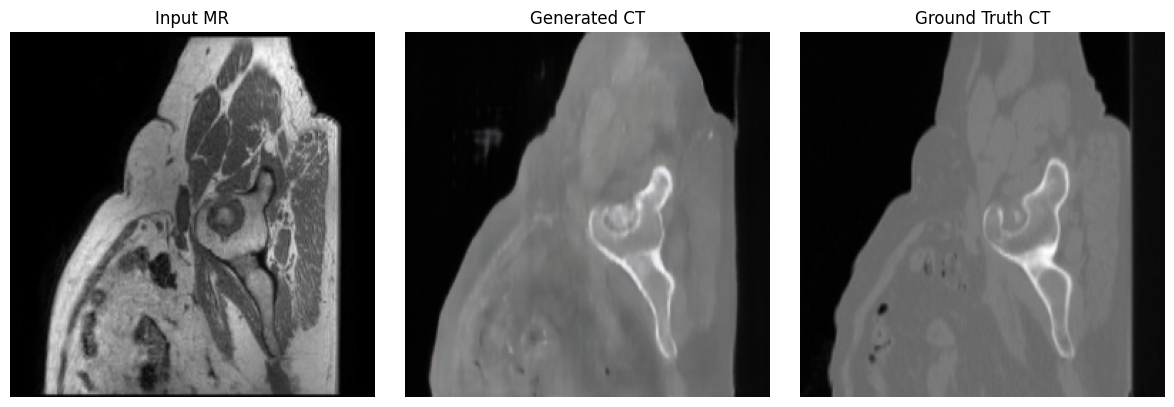

Press Enter to continue... 


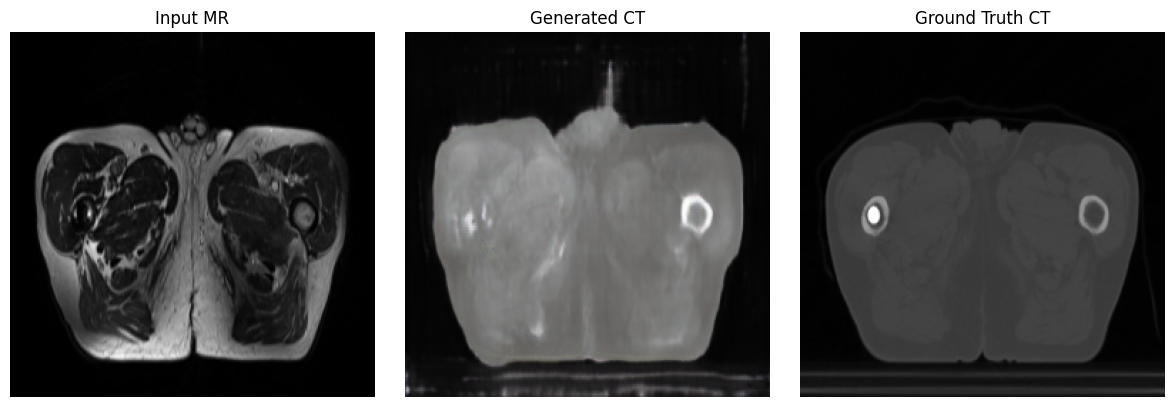

Press Enter to continue... 


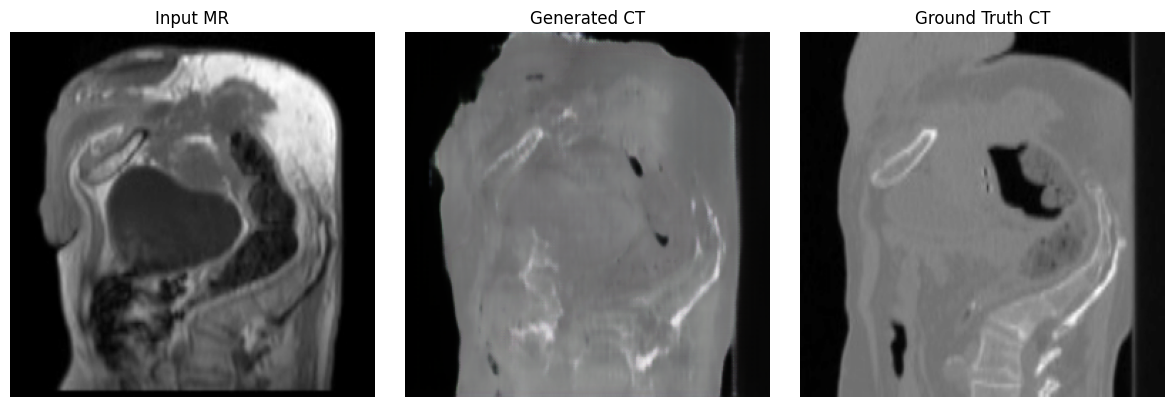

Press Enter to continue... 


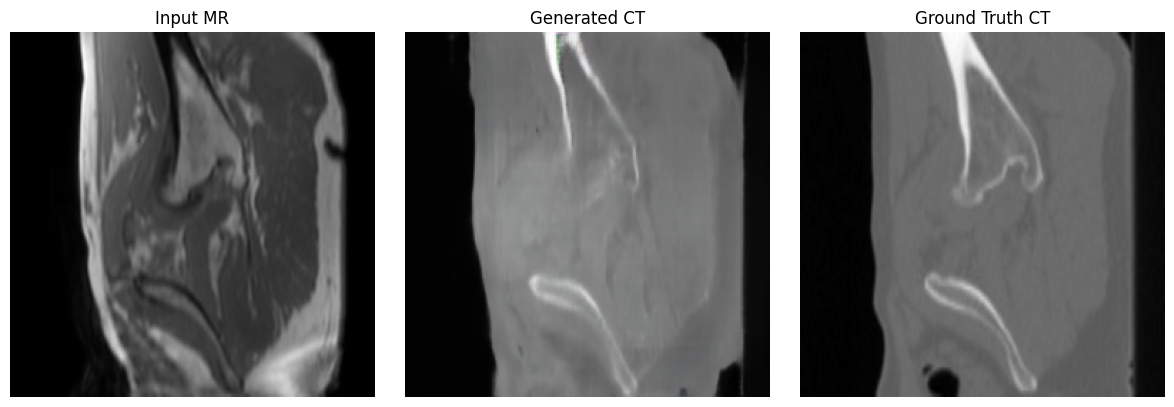

Press Enter to continue... 


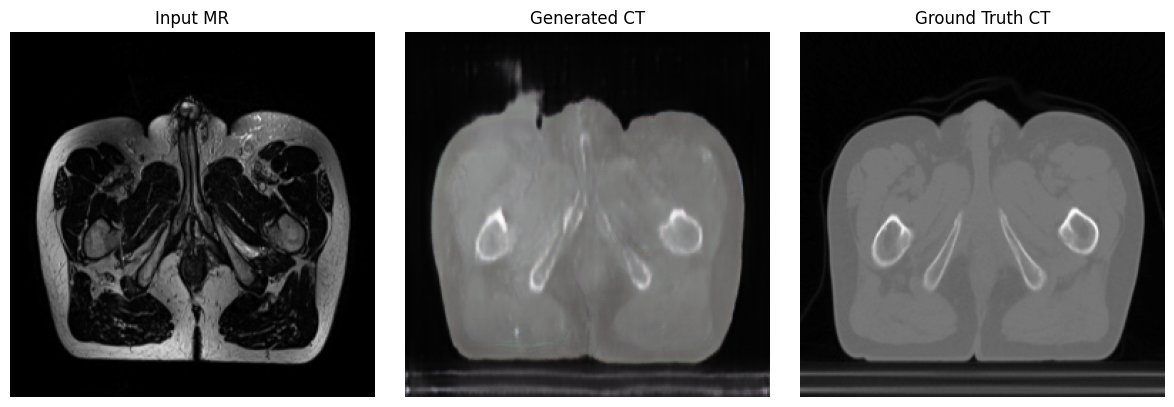

Press Enter to continue... 


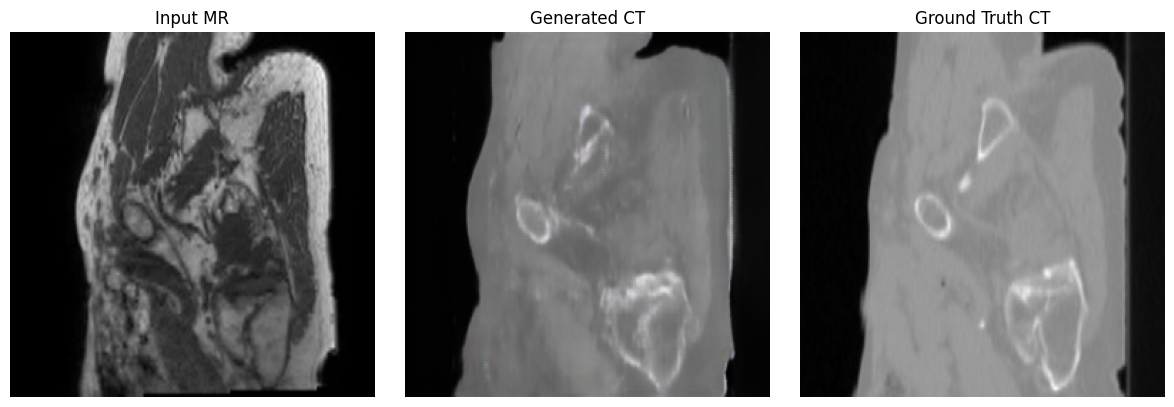

Press Enter to continue... 


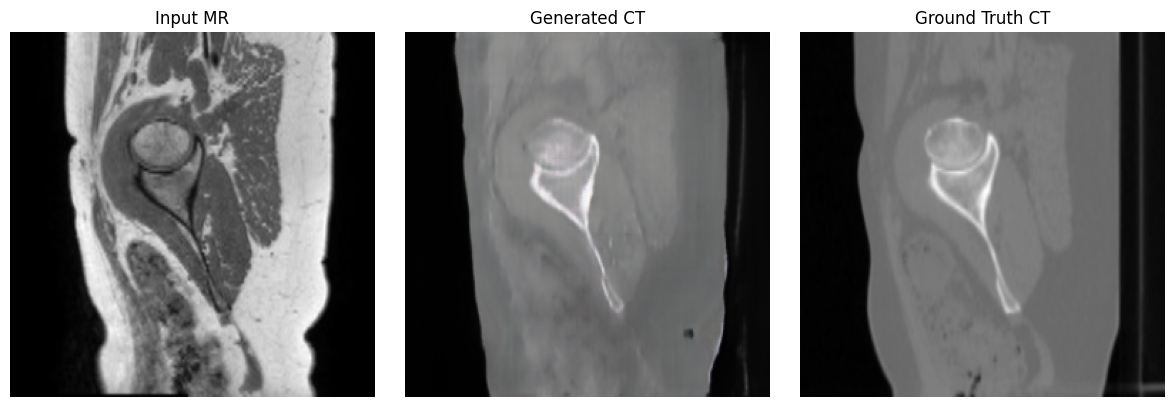

In [ ]:
with torch.no_grad():
    for idx, (mr, ct) in enumerate(val_loader):
        mr = mr.to('cuda:2')
        ct = ct.to('cuda:2')

        fake_ct = gen(mr)

        # Denormalize
        # mr = denormalize(mr)
        # ct = denormalize(ct)
        # fake_ct = denormalize(fake_ct)

        # Convert to numpy (shape: C x H x W -> H x W x C)
        mr_np = mr.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        ct_np = ct.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        fake_ct_np = fake_ct.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

        # Convert to uint8 for proper visualization (optional)
        mr_np = (mr_np * 255).astype('uint8')
        ct_np = (ct_np * 255).astype('uint8')
        fake_ct_np = (fake_ct_np * 255).astype('uint8')

        # Show images side by side
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(cv2.cvtColor(mr_np, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Input MR')
        axs[1].imshow(cv2.cvtColor(fake_ct_np, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Generated CT')
        axs[2].imshow(cv2.cvtColor(ct_np, cv2.COLOR_BGR2RGB))
        axs[2].set_title('Ground Truth CT')

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        input("Press Enter to continue...")

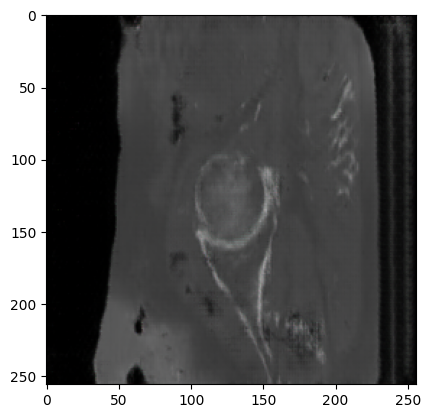

In [11]:
plt.imshow(fake_ct_np)

PSNR: 25.5002 dB
SSIM: 0.7358
MAE:  8.2937
